In [ ]:
import os
import sys
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import math

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

ROOT = Path(os.getcwd()).parents[0]
path_data = os.path.join(Path(ROOT), "data")

In [ ]:
# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

# Import funtion/classes from source code
from fingerprint_computation import compute_fingerprints_from_smiles
from metrics import ruzicka_similarity_matrix_sparse, jaccard_similarity_matrix_sparse
from metrics import ruzicka_similarity_matrix, jaccard_similarity_matrix

from map4 import MAP4
#from mbp import MBP

In [3]:
from typing import List
from rdkit.Chem import Mol, MolFromSmiles

def compute_map_fingerprints_from_smiles(smiles, map_generator):
    
    molecules: List[Mol] = [MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many(
        molecules,
        number_of_threads=32,
        verbose=True,
    )
    return fingerprints_map


def compute_sparse_map_fingerprints_from_smiles(
    smiles,
    map_generator,
    count=False,
    ):
    molecules: List[Mol] = [MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many_sparse(
        molecules,
        number_of_threads=32,
        verbose=True,
        count=count,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles_serial(
        smiles,
        map_generator,
        count=False
        ):

    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints = []
    for mol in tqdm(molecules):
        if count:
            fp = map_generator.calculate_sparse(mol, count=count)
            fingerprints.append(fp)
        else:
            fp_bits = map_generator._calculate(mol)
            fingerprints.append(np.sort(map_generator.encoder.hash(fp_bits)))
    return fingerprints

In [4]:
def compute_fingerprints_from_smiles_numpy(smiles, fpgen, count, sparse, bit_scaling=None):
    fingerprints = compute_fingerprints_from_smiles(
        smiles, fpgen, sparse=sparse,
        count=count, progress_bar=False, bit_scaling=bit_scaling
    )
    return np.stack(fingerprints)

In [5]:
rdkitgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096)

fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)
fpgen9 = rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096)
fpgen12 = rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096)

map2gen = MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False)
map4gen = MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False)

fingerprint_functions_new = {
    "rdkit": lambda smiles: compute_fingerprints_from_smiles_numpy(smiles, rdkitgen, count=False, sparse=False),
    "rdkit_sparse": lambda smiles: compute_fingerprints_from_smiles(smiles, rdkitgen, count=False, sparse=True),
    "m3cfp": lambda smiles: compute_fingerprints_from_smiles_numpy(smiles, fpgen, count=True, sparse=False),
    "m3lcfp": lambda smiles: compute_fingerprints_from_smiles_numpy(smiles, fpgen, count=True, sparse=False, bit_scaling="log"),
    "m3bfp": lambda smiles: compute_fingerprints_from_smiles_numpy(smiles, fpgen, count=False, sparse=False),
    "m9cfp": lambda smiles: compute_fingerprints_from_smiles_numpy(smiles, fpgen9, count=True, sparse=False),
    "m9lcfp": lambda smiles: compute_fingerprints_from_smiles_numpy(smiles, fpgen9, count=True, sparse=False, bit_scaling="log"),
    "m9bfp": lambda smiles: compute_fingerprints_from_smiles_numpy(smiles, fpgen9, count=False, sparse=False),
    "m12cfp": lambda smiles: compute_fingerprints_from_smiles_numpy(smiles, fpgen12, count=True, sparse=False),
    "m12lcfp": lambda smiles: compute_fingerprints_from_smiles_numpy(smiles, fpgen12, count=True, sparse=False, bit_scaling="log"),
    "m12bfp": lambda smiles: compute_fingerprints_from_smiles_numpy(smiles, fpgen12, count=False, sparse=False),
    "m3cfp_sparse": lambda smiles: compute_fingerprints_from_smiles(smiles, fpgen, count=True, sparse=True),
    "m3lcfp_sparse": lambda smiles: compute_fingerprints_from_smiles(smiles, fpgen, count=True, sparse=True, bit_scaling="log"),
    "m3bfp_sparse": lambda smiles: compute_fingerprints_from_smiles(smiles, fpgen, count=False, sparse=True),
    "m9cfp_sparse": lambda smiles: compute_fingerprints_from_smiles(smiles, fpgen9, count=True, sparse=True),
    "m9lcfp_sparse": lambda smiles: compute_fingerprints_from_smiles(smiles, fpgen9, count=True, sparse=True, bit_scaling="log"),
    "m9bfp_sparse": lambda smiles: compute_fingerprints_from_smiles(smiles, fpgen9, count=False, sparse=True),
    "m12cfp_sparse": lambda smiles: compute_fingerprints_from_smiles(smiles, fpgen12, count=True, sparse=True),
    "m12lcfp_sparse": lambda smiles: compute_fingerprints_from_smiles(smiles, fpgen12, count=True, sparse=True, bit_scaling="log"),
    "m12bfp_sparse": lambda smiles: compute_fingerprints_from_smiles(smiles, fpgen12, count=False, sparse=True),
    #"map2_sparse": lambda smiles: compute_sparse_map_fingerprints_from_smiles_serial(smiles, map2gen),
    #"map4_sparse": lambda smiles: compute_sparse_map_fingerprints_from_smiles_serial(smiles, map4gen),
}

distance_functions = {
    "rdkit": lambda querys, compounds: 1 - jaccard_similarity_matrix(querys, compounds),
    "rdkit_sparse": lambda querys, compounds: 1 - jaccard_similarity_matrix_sparse(querys, compounds),
    "m3cfp": lambda querys, compounds: 1 - ruzicka_similarity_matrix(querys, compounds),
    "m3lcfp": lambda querys, compounds: 1 - ruzicka_similarity_matrix(querys, compounds),
    "m3bfp": lambda querys, compounds: 1 - jaccard_similarity_matrix(querys, compounds),
    "m9cfp": lambda querys, compounds: 1 - ruzicka_similarity_matrix(querys, compounds),
    "m9lcfp": lambda querys, compounds: 1 - ruzicka_similarity_matrix(querys, compounds),
    "m9bfp": lambda querys, compounds: 1 - jaccard_similarity_matrix(querys, compounds),
    "m12cfp": lambda querys, compounds: 1 - ruzicka_similarity_matrix(querys, compounds),
    "m12lcfp": lambda querys, compounds: 1 - ruzicka_similarity_matrix(querys, compounds),
    "m12bfp": lambda querys, compounds: 1 - jaccard_similarity_matrix(querys, compounds),
    "m3cfp_sparse": lambda querys, compounds: 1 - ruzicka_similarity_matrix_sparse(querys, compounds),
    "m3lcfp_sparse": lambda querys, compounds: 1 - ruzicka_similarity_matrix_sparse(querys, compounds),
    "m3bfp_sparse": lambda querys, compounds: 1 - jaccard_similarity_matrix_sparse(querys, compounds),
    "m9cfp_sparse": lambda querys, compounds: 1 - ruzicka_similarity_matrix_sparse(querys, compounds),
    "m9lcfp_sparse": lambda querys, compounds: 1 - ruzicka_similarity_matrix_sparse(querys, compounds),
    "m9bfp_sparse": lambda querys, compounds: 1 - jaccard_similarity_matrix_sparse(querys, compounds),
    "m12cfp_sparse": lambda querys, compounds: 1 - ruzicka_similarity_matrix_sparse(querys, compounds),
    "m12lcfp_sparse": lambda querys, compounds: 1 - ruzicka_similarity_matrix_sparse(querys, compounds),
    "m12bfp_sparse": lambda querys, compounds: 1 - jaccard_similarity_matrix_sparse(querys, compounds),
    #"map2_sparse": lambda querys, compounds: 1 - jaccard_similarity_matrix_sparse(querys, compounds),
    #"map4_sparse": lambda querys, compounds: 1 - jaccard_similarity_matrix_sparse(querys, compounds),
}


## Compute scores

In [6]:
list(distance_functions.keys())

['rdkit',
 'rdkit_sparse',
 'm3cfp',
 'm3lcfp',
 'm3bfp',
 'm9cfp',
 'm9lcfp',
 'm9bfp',
 'm12cfp',
 'm12lcfp',
 'm12bfp',
 'm3cfp_sparse',
 'm3lcfp_sparse',
 'm3bfp_sparse',
 'm9cfp_sparse',
 'm9lcfp_sparse',
 'm9bfp_sparse',
 'm12cfp_sparse',
 'm12lcfp_sparse',
 'm12bfp_sparse']

In [ ]:
# better like this:
from multiprocessing import Pool

fingerprint_names = [
    'rdkit',
    'rdkit_sparse',
    'm3cfp',
    'm3lcfp',
    'm3bfp',
    'm9cfp',
    'm9lcfp',
    'm9bfp',
    'm12cfp',
    'm12lcfp',
    'm12bfp',
    'm3cfp_sparse',
    'm3lcfp_sparse',
    'm3bfp_sparse',
    'm9cfp_sparse',
    'm9lcfp_sparse',
    'm9bfp_sparse',
    'm12cfp_sparse',
    'm12lcfp_sparse',
    'm12bfp_sparse',
]

datasets = [
    'ChEMBL',
    'DUD',
    'MUV',
    #'PeptidesM',
    #'Peptides',
]

In [20]:
fingerprint = "rdkit" #,"m3bfp" #"m3cfp"

In [21]:
dataset = "ChEMBL"

dataset_path = os.path.join('..', '..', 'map4chiral', 'benchmark', 'compounds', dataset)

file = os.listdir(dataset_path)[0]

dataset_path = os.path.join('..', '..', 'map4chiral', 'benchmark', 'compounds', dataset)
queries_path = os.path.join('..', '..', 'map4chiral', 'benchmark', 'queries', dataset)

# Load the dataset and the corresponding queries file
file_path = os.path.join(dataset_path, file)
file_dataset = pd.read_csv(file_path)
# Assumes query filename is based on the dataset file name
base_filename = file.split(".")[0]
queries_file = os.path.join(queries_path, f'{base_filename}_queries.csv')
file_queries = pd.read_csv(queries_file)

# Create a copy to add the computed fingerprint columns
output_df = file_dataset.copy()

# Get the smiles values (assuming a column named 'smiles')
smiles_dataset = file_dataset['smiles'].values
smiles_queries = file_queries['smiles'].values

In [22]:
set_fingerprints = fingerprint_functions_new[fingerprint](smiles_dataset)
query_fingerprints = fingerprint_functions_new[fingerprint](smiles_queries)

In [23]:
set_fingerprints.shape, query_fingerprints.shape, query_fingerprints[0].shape

((10100, 4096), (5, 4096), (4096,))

In [24]:
distances = distance_functions[fingerprint](
    query_fingerprints[0].reshape(1, -1), set_fingerprints)[0]

In [25]:
distances.shape, distances.min(), distances.max()

((10100,), np.float32(0.0), np.float32(0.96856904))

In [26]:
from metrics import jaccard_index

jaccard_index(query_fingerprints[0], set_fingerprints[0])

0.25190839694656486

In [27]:
from metrics import ruzicka_similarity

ruzicka_similarity(query_fingerprints[0], set_fingerprints[0])

0.25190839694656486

In [27]:
1 - distances[0]

np.float32(0.12162161)

In [87]:
def compute_fingerprint_columns(fingerprint, smiles_dataset, smiles_queries):
    """
    Worker function that computes the fingerprint for a given fingerprint type.
    It computes the fingerprint vectors for both the dataset and the query smiles,
    then, for each query, computes the distances to every compound in the dataset.
    Returns a dictionary mapping new column names to their computed distance lists.
    """
    # Compute fingerprints for dataset and queries
    set_fingerprints = fingerprint_functions_new[fingerprint](smiles_dataset)
    query_fingerprints = fingerprint_functions_new[fingerprint](smiles_queries)
    distance_function = distance_functions[fingerprint]

    result = {}
    # For every query fingerprint compute distances to every compound fingerprint
    for idx, query in enumerate(query_fingerprints):
        if "_sparse" in fingerprint:
            distances = distance_function([query], set_fingerprints)[0]
        else:
            distances = distance_function(query.reshape(1, -1), set_fingerprints)[0]
        # Create a new column name; for example: "m3cfp_0", "m3cfp_1", etc.
        result[f'{fingerprint}_{idx}'] = distances
    return result


def process_file(dataset, file, pool):
    """
    Process a single file: load the compounds and queries, then for each fingerprint,
    compute the distance columns in parallel. The computed columns are then added to
    a copy of the dataset and written to disk.
    """
    # Define paths
    dataset_path = os.path.join('..', '..', 'map4chiral', 'benchmark', 'compounds', dataset)
    queries_path = os.path.join('..', '..', 'map4chiral', 'benchmark', 'queries', dataset)

    # Load the dataset and the corresponding queries file
    file_path = os.path.join(dataset_path, file)
    file_dataset = pd.read_csv(file_path)
    # Assumes query filename is based on the dataset file name
    base_filename = file.split(".")[0]
    queries_file = os.path.join(queries_path, f'{base_filename}_queries.csv')
    file_queries = pd.read_csv(queries_file)

    # Create a copy to add the computed fingerprint columns
    output_df = file_dataset.copy()
    
    # Get the smiles values (assuming a column named 'smiles')
    smiles_dataset = file_dataset['smiles'].values
    smiles_queries = file_queries['smiles'].values

    # Create tasks for each fingerprint type; each task is a tuple of arguments
    tasks = [(fingerprint, smiles_dataset, smiles_queries) for fingerprint in fingerprint_names]

    # Use pool.starmap to distribute the fingerprint computations across the worker processes
    results = pool.starmap(compute_fingerprint_columns, tasks)

    # Add each fingerprint’s computed columns into the output DataFrame
    all_cols = {}
    for fingerprint_result in results:
        all_cols.update(fingerprint_result)
    
    distances_df = pd.DataFrame(all_cols, index=file_dataset.index)
    output_df = pd.concat([file_dataset, distances_df], axis=1)

    # Create the output directory (if needed) and write the resulting CSV
    out_dir = os.path.join("..", "benchmarking", dataset)
    os.makedirs(out_dir, exist_ok=True)
    out_file = os.path.join(out_dir, f'{base_filename}_scored_2025_03.csv')
    output_df.to_csv(out_file, index=False)
    print(f"Just saved {out_file}")


def process_dataset(dataset, pool):
    """
    Process all files for a given dataset. For each file in the dataset folder,
    the fingerprint columns are computed in parallel.
    """
    dataset_path = os.path.join('..', '..', 'map4chiral', 'benchmark', 'compounds', dataset)
    out_dir = os.path.join("..", "benchmarking", dataset)
    for file in os.listdir(dataset_path):
        if os.path.exists(os.path.join(out_dir, f'{file.split(".")[0]}_scored_2025_03.csv')):
            print(f"Skip already existing file {file}")
        else:
            process_file(dataset, file, pool)


if __name__ == '__main__':
    # Create a pool of worker processes.
    pool = Pool(processes=24)

    # Loop over all datasets (outer loop) and process their files.
    # The inner work (computing fingerprint columns) is distributed in parallel.
    for dataset in datasets:
        process_dataset(dataset, pool)

    # Clean up the pool.
    pool.close()
    pool.join()

Skip already existing file PeptidesM_RYAWTRHFAIFVVDV.csv
Skip already existing file PeptidesM_IDIIIRTHES.csv
Skip already existing file PeptidesM_NAPSYKTFEANITTRAARNS.csv
Skip already existing file PeptidesM_LFCCVAYSFD.csv
Skip already existing file PeptidesM_RTVSFSYCRQDCQPF.csv
Skip already existing file PeptidesM_VNWVWDHFSR.csv
Skip already existing file PeptidesM_VGPYVKHPAEACNQQ.csv
Skip already existing file PeptidesM_SPYDQEMDQQFDRACCWHFK.csv
Skip already existing file PeptidesM_KAQIDLSPNP.csv
Skip already existing file PeptidesM_SSQHVQRENY.csv
Skip already existing file PeptidesM_VPMMTDGIMTVYVGGEPWSR.csv
Skip already existing file PeptidesM_DHVRWIFWHAAICCD.csv
Skip already existing file PeptidesM_HAETEGYKSSPTKLGCDPLY.csv
Skip already existing file PeptidesM_TITVVSLMNQ.csv
Skip already existing file PeptidesM_FPGFIAKCTQWGAGLEVGGH.csv
Skip already existing file PeptidesM_RWPWKPFHVRFFFQRWPLLH.csv
Skip already existing file PeptidesM_FGDWRAGYGGSPENL.csv
Skip already existing file Pept

In [83]:
out_dir = os.path.join("..", "benchmarking", dataset)
os.path.join(out_dir, f'{file.split(".")[0]}_scored_2025_03.csv')

'../benchmarking/PeptidesM/Peptides_RWPWKPFHVRFFFQRWPLLH_validated_2025_2_scored_2025_03.csv'

In [79]:
datasets = [
    #'ChEMBL',
    #'DUD',
    #'MUV',
    'PeptidesM',
    'Peptides',
]

In [ ]:
datasets = [
    'ChEMBL',
    'DUD',
    'MUV',
    #'PeptidesM',
    #'Peptides',
]

# Validation part

In [10]:
from rdkit.ML.Scoring import Scoring

def calc_auc(data, column_name):
    sorted_data = data.sort_values(by=column_name, ascending=True)[['active', column_name]].values
    return Scoring.CalcAUC(sorted_data, 0)

def calc_ef1(data, column_name):
    sorted_data = data.sort_values(by=column_name, ascending=True)[['active', column_name]].values
    return Scoring.CalcEnrichment(sorted_data, 0, [0.01])

def calc_ef5(data, column_name):
    sorted_data = data.sort_values(by=column_name, ascending=True)[['active', column_name]].values
    return Scoring.CalcEnrichment(sorted_data, 0, [0.05])

def calc_bedroc20(data, column_name):
    sorted_data = data.sort_values(by=column_name, ascending=True)[['active', column_name]].values
    return Scoring.CalcBEDROC(sorted_data, 0, 20)

def calc_bedroc100(data, column_name):
    sorted_data = data.sort_values(by=column_name, ascending=True)[['active', column_name]].values
    return Scoring.CalcBEDROC(sorted_data, 0, 100)

def calc_rie20(data, column_name):
    sorted_data = data.sort_values(by=column_name, ascending=True)[['active', column_name]].values
    return Scoring.CalcRIE(sorted_data, 0, 20)

def calc_rie100(data, column_name):
    sorted_data = data.sort_values(by=column_name, ascending=True)[['active', column_name]].values
    return Scoring.CalcRIE(sorted_data, 0, 100)

In [92]:
fingerprint_names

['map2c',
 'map2',
 'map4c',
 'map4',
 'map6c',
 'map6',
 'ecfp4c',
 'ecfp4',
 'ecfp6c',
 'ecfp6',
 'apc',
 'ap',
 'rdkit',
 'rdkit_sparse',
 'm3cfp',
 'm3lcfp',
 'm3bfp',
 'm9cfp',
 'm9lcfp',
 'm9bfp',
 'm12cfp',
 'm12lcfp',
 'm12bfp',
 'm3cfp_sparse',
 'm3lcfp_sparse',
 'm3bfp_sparse',
 'm9cfp_sparse',
 'm9lcfp_sparse',
 'm9bfp_sparse',
 'm12cfp_sparse',
 'm12lcfp_sparse',
 'm12bfp_sparse']

In [94]:
# Define the number of queries and the names of the used fingerprints
num_queries = 5

# Generate the column names from the fingerprint names and the number of queries
distance_columns = []
for fingerprint in fingerprint_names:
    for query_num in range(num_queries):
        distance_columns.append(f"{fingerprint}_{query_num}")


datasets = ['ChEMBL', 'DUD', 'MUV', 'PeptidesM', 'Peptides']
for dataset in datasets:
    print(dataset)
    dataset_path = f'../benchmarking/{dataset}'
    output_dir = f'{dataset}'
    
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Iterate over all files in the dataset directory
    for file in tqdm(os.listdir(dataset_path)):
        if file.endswith('scored_2025_03.csv'):
    
            # Load the data
            data = pd.read_csv(os.path.join(dataset_path, file))
    
            # Calculate the AUC, EF1, EF5, BEDROC20, BEDROC100, RIE20, and RIE100 for each column. Reshape the results to a 2D array with the shape (len(fingerprint_names), num_queries)
            aucs = np.array([calc_auc(data, column_name) for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            ef1s = np.array([calc_ef1(data, column_name)[0] for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            ef5s = np.array([calc_ef5(data, column_name)[0]for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            bedroc20s = np.array([calc_bedroc20(data, column_name) for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            bedroc100s = np.array([calc_bedroc100(data, column_name) for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            rie20s = np.array([calc_rie20(data, column_name) for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            rie100s = np.array([calc_rie100(data, column_name) for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
    
            # For each fingerprint, determine the mean and std. dev of the 5 queries 
            aucs_mean = np.mean(aucs, axis=1)
            aucs_std = np.std(aucs, axis=1)
            ef1s_mean = np.mean(ef1s, axis=1)
            ef1s_std = np.std(ef1s, axis=1)
            ef5s_mean = np.mean(ef5s, axis=1)
            ef5s_std = np.std(ef5s, axis=1)
            bedroc20s_mean = np.mean(bedroc20s, axis=1)
            bedroc20s_std = np.std(bedroc20s, axis=1)
            bedroc100s_mean = np.mean(bedroc100s, axis=1)
            bedroc100s_std = np.std(bedroc100s, axis=1)
            rie20s_mean = np.mean(rie20s, axis=1)
            rie20s_std = np.std(rie20s, axis=1)
            rie100s_mean = np.mean(rie100s, axis=1)
            rie100s_std = np.std(rie100s, axis=1)
    
            # Generate a dataframe with the results
            output_df = pd.DataFrame({'fingerprint': fingerprint_names, 'auc_mean': aucs_mean, 'auc_std': aucs_std, 'ef1_mean': ef1s_mean, 'ef1_std': ef1s_std, 'ef5_mean': ef5s_mean, 'ef5_std': ef5s_std, 'bedroc20_mean': bedroc20s_mean, 'bedroc20_std': bedroc20s_std, 'bedroc100_mean': bedroc100s_mean, 'bedroc100_std': bedroc100s_std, 'rie20_mean': rie20s_mean, 'rie20_std': rie20s_std, 'rie100_mean': rie100s_mean, 'rie100_std': rie100s_std})
            
            # Save the results to a csv file
            filename = file.split('_')[0] + '_' + file.split('_')[1]
            output_df.to_csv(f'{dataset}/{filename}_validated_2025_03.csv', index=False)


ChEMBL


  0%|          | 0/480 [00:00<?, ?it/s]

KeyError: 'map2c_0'

In [13]:
data.head()

,name,id,smiles,active,rdkit_0,rdkit_1,rdkit_2,rdkit_3,rdkit_4,rdkit_sparse_0,...,m12lcfp_sparse_0,m12lcfp_sparse_1,m12lcfp_sparse_2,m12lcfp_sparse_3,m12lcfp_sparse_4,m12bfp_sparse_0,m12bfp_sparse_1,m12bfp_sparse_2,m12bfp_sparse_3,m12bfp_sparse_4
0,647427,MUV_600_A_1,CCc1ccc(-c2nnn(CCC(=O)OC)n2)cc1,1,0.864845,0.907274,0.828031,0.872928,0.826693,0.953349,...,0.922493,0.930766,0.872918,0.927106,0.913408,0.940909,0.952941,0.897561,0.942029,0.938462
1,655381,MUV_600_A_2,Cc1ccccc1NC(=O)N1CCCC(c2nc(-c3ccc(C(C)C)cc3)no...,1,0.835587,0.827321,0.736271,0.818313,0.730361,0.975410,...,0.930644,0.941598,0.910661,0.903917,0.871104,0.948529,0.968750,0.931034,0.929134,0.902299
2,658729,MUV_600_A_3,Cc1ccc2[nH]c3c(ncnc3N3CCN(Cc4ccc5c(c4)OCO5)CC3...,1,0.682558,0.672578,0.831285,0.730198,0.862850,0.806222,...,0.872526,0.867162,0.935609,0.943353,0.915899,0.892308,0.906103,0.951493,0.962121,0.939560
3,659314,MUV_600_A_4,O=C(c1ccc2c3c1cccc3C(=O)N(O)C2=O)N1CCCCC1,1,0.818369,0.874728,0.843284,0.816959,0.892944,0.914634,...,0.921696,0.926730,0.926853,0.912804,0.928420,0.940909,0.959064,0.948837,0.936893,0.954545
4,659623,MUV_600_A_5,Fc1ccc2[nH]c3c(ncnc3N3CCN(Cc4ccc5c(c4)OCO5)CC3...,1,0.682759,0.673750,0.831771,0.729902,0.859587,0.808436,...,0.876542,0.867162,0.942986,0.947051,0.942504,0.896552,0.906103,0.959259,0.966038,0.967914


In [14]:
output_df

,fingerprint,auc_mean,auc_std,ef1_mean,ef1_std,ef5_mean,ef5_std,bedroc20_mean,bedroc20_std,bedroc100_mean,bedroc100_std,rie20_mean,rie20_std,rie100_mean,rie100_std
0,rdkit,0.614813,0.052510,7.962914,3.981457,3.864096,1.422664,0.170133,0.051069,0.091297,0.039303,3.335644,1.001271,8.276311,3.562872
1,rdkit_sparse,0.570749,0.036973,7.299338,3.869281,4.397074,0.903709,0.178180,0.048448,0.090546,0.037697,3.493401,0.949872,8.208221,3.417272
2,m3cfp,0.612336,0.044383,7.962914,6.501692,2.931383,1.305526,0.145014,0.057189,0.083258,0.055721,2.843158,1.121245,7.547475,5.051272
3,m3lcfp,0.612336,0.044383,7.962914,6.501692,2.931383,1.305526,0.145014,0.057189,0.083258,0.055721,2.843158,1.121245,7.547475,5.051272
4,m3bfp,0.565993,0.051368,8.626490,7.738561,3.064628,1.235660,0.142134,0.054373,0.085442,0.056566,2.786681,1.066044,7.745466,5.127872
5,m9cfp,0.577860,0.044780,8.626490,7.738561,2.664894,1.332447,0.129270,0.059984,0.080744,0.057158,2.534475,1.176046,7.319635,5.181456
6,m9lcfp,0.577860,0.044780,8.626490,7.738561,2.664894,1.332447,0.129270,0.059984,0.080744,0.057158,2.534475,1.176046,7.319635,5.181456
7,m9bfp,0.534254,0.055246,8.626490,7.738561,2.798138,1.065957,0.130435,0.055975,0.080033,0.054142,2.557310,1.097449,7.255200,4.908108
8,m12cfp,0.577429,0.044642,8.626490,7.738561,2.798138,1.422664,0.129510,0.059917,0.080695,0.057059,2.539182,1.174735,7.315151,5.172500
9,m12lcfp,0.577429,0.044642,8.626490,7.738561,2.798138,1.422664,0.129510,0.059917,0.080695,0.057059,2.539182,1.174735,7.315151,5.172500


In [15]:
fingerprint_names

['rdkit',
 'rdkit_sparse',
 'm3cfp',
 'm3lcfp',
 'm3bfp',
 'm9cfp',
 'm9lcfp',
 'm9bfp',
 'm12cfp',
 'm12lcfp',
 'm12bfp',
 'm3cfp_sparse',
 'm3lcfp_sparse',
 'm3bfp_sparse',
 'm9cfp_sparse',
 'm9lcfp_sparse',
 'm9bfp_sparse',
 'm12cfp_sparse',
 'm12lcfp_sparse',
 'm12bfp_sparse']

In [17]:
metrics = ['auc_mean', 'ef1_mean', 'ef5_mean', 'bedroc20_mean', 'bedroc100_mean', 'rie20_mean', 'rie100_mean']

datasets = ['ChEMBL', 'DUD', 'MUV', 'PeptidesM', 'Peptides']
fingerprint_names = [
    'map2c', 'map2',
    'map4c', 'map4',
    'map6c', 'map6',
    'ecfp4c', 'ecfp4', 'ecfp6c', 'ecfp6', 'apc', 'ap',
    'rdkit',
    'rdkit_sparse',
    'm3cfp',
    'm3lcfp',
    'm3bfp',
    'm9cfp',
    'm9lcfp',
    'm9bfp',
    'm12cfp',
    'm12lcfp',
    'm12bfp',
    'm3cfp_sparse',
    'm3lcfp_sparse',
    'm3bfp_sparse',
    'm9cfp_sparse',
    'm9lcfp_sparse',
    'm9bfp_sparse',
    'm12cfp_sparse',
    'm12lcfp_sparse',
    'm12bfp_sparse'
]


#for dataset in datasets:
# Iterate over metrics
for metric in metrics:

    # Initialize output dataframe
    output_df = pd.DataFrame(columns=fingerprint_names)

    # Iterate over datasets
    for dataset in datasets:
        dataset_path = f'../../map4chiral/benchmark/validation/{dataset}'

        # Iterate over files
        for file in os.listdir(dataset_path):
            data = pd.read_csv(os.path.join(dataset_path, file))[metric].values
            output_df.loc[len(output_df), fingerprint_names[:12]] = data

    # Iterate over datasets
    count = 0
    for dataset in datasets:
        dataset_path = f'{dataset}'

        # Iterate over files
        for i, file in enumerate(os.listdir(dataset_path)):
            if file.endswith('2025_03.csv'):
                data = pd.read_csv(os.path.join(dataset_path, file))[metric].values
                output_df.loc[count, fingerprint_names[12:]] = data
                count += 1
    
    # Create output directory
    if not os.path.exists('combined_sets'):
        os.makedirs('combined_sets')
    
    # Save output dataframe
    output_df.to_csv(f'combined_sets/{metric}_benchmarking_2025_06_03.csv', index=False)

In [18]:
data

array([5.2874218 , 5.32909133, 4.90863667, 4.90863667, 5.22568509,
       4.66641234, 4.66641234, 4.9380599 , 4.66683462, 4.66683462,
       4.93745439, 4.9293794 , 5.01614285, 5.23042889, 4.79459434,
       4.88936422, 4.99834376, 4.79488279, 4.89136442, 4.99979918])

In [19]:
i, data, count

(61,
 array([5.2874218 , 5.32909133, 4.90863667, 4.90863667, 5.22568509,
        4.66641234, 4.66641234, 4.9380599 , 4.66683462, 4.66683462,
        4.93745439, 4.9293794 , 5.01614285, 5.23042889, 4.79459434,
        4.88936422, 4.99834376, 4.79488279, 4.89136442, 4.99979918]),
 118)

In [20]:
auc = pd.read_csv('combined_sets/auc_mean_benchmarking_2025_06_03.csv')
ef1 = pd.read_csv('combined_sets/ef1_mean_benchmarking_2025_06_03.csv')
ef5 = pd.read_csv('combined_sets/ef5_mean_benchmarking_2025_06_03.csv')
bedroc20 = pd.read_csv('combined_sets/bedroc20_mean_benchmarking_2025_06_03.csv')
bedroc100 = pd.read_csv('combined_sets/bedroc100_mean_benchmarking_2025_06_03.csv')
rie20 = pd.read_csv('combined_sets/rie20_mean_benchmarking_2025_06_03.csv')
rie100 = pd.read_csv('combined_sets/rie100_mean_benchmarking_2025_06_03.csv')

In [21]:
auc.iloc[80:100]

,map2c,map2,map4c,map4,map6c,map6,ecfp4c,ecfp4,ecfp6c,ecfp6,...,m12bfp,m3cfp_sparse,m3lcfp_sparse,m3bfp_sparse,m9cfp_sparse,m9lcfp_sparse,m9bfp_sparse,m12cfp_sparse,m12lcfp_sparse,m12bfp_sparse
80,0.845456,0.853697,0.835640,0.832432,0.834624,0.837548,0.852259,0.850081,0.834444,0.834308,...,0.703240,0.590553,0.636370,0.698759,0.588777,0.631786,0.689901,0.588777,0.631786,0.689901
81,0.591821,0.583008,0.627047,0.589454,0.620338,0.588011,0.681961,0.669112,0.664201,0.678897,...,0.521445,0.446108,0.466210,0.503885,0.442977,0.463034,0.504407,0.442977,0.463034,0.504407
82,0.702825,0.707756,0.695565,0.703581,0.691843,0.711556,0.651341,0.633524,0.663704,0.650069,...,0.518743,0.504093,0.496991,0.515958,0.537182,0.527122,0.542466,0.537209,0.527181,0.542573
83,0.768366,0.681228,0.744843,0.659591,0.722701,0.651758,0.788774,0.771601,0.795155,0.784255,...,0.845996,0.860291,0.873801,0.861481,0.877557,0.888076,0.873185,0.877557,0.888076,0.873185
84,0.893805,0.875807,0.909513,0.881642,0.900394,0.884803,0.828684,0.802121,0.831985,0.800145,...,0.654411,0.620047,0.626659,0.641235,0.627767,0.633147,0.645120,0.627767,0.633150,0.645124
85,0.759260,0.779969,0.764714,0.775237,0.767357,0.779477,0.639995,0.639351,0.651953,0.645495,...,0.691780,0.627303,0.656728,0.689901,0.615082,0.642814,0.675486,0.615021,0.642724,0.675365
86,0.828590,0.808976,0.870020,0.831563,0.867394,0.840283,0.894696,0.900930,0.882401,0.885957,...,0.928406,0.829896,0.869833,0.908007,0.845944,0.885214,0.921982,0.845944,0.885214,0.921982
87,0.802407,0.806447,0.797094,0.802451,0.797216,0.798629,0.791422,0.791445,0.788339,0.790168,...,0.956062,0.946953,0.954337,0.959646,0.937266,0.945668,0.952808,0.937266,0.945668,0.952808
88,0.715297,0.725439,0.697917,0.707969,0.683828,0.709153,0.676244,0.676744,0.685296,0.679567,...,0.556521,0.499426,0.490608,0.515531,0.547666,0.538846,0.566570,0.547789,0.539065,0.566798
89,0.472677,0.448286,0.476212,0.451554,0.477141,0.450343,0.534014,0.529475,0.493039,0.489213,...,0.927481,0.848731,0.881728,0.916740,0.863411,0.898361,0.930570,0.863411,0.898361,0.930570


In [22]:
auc

,map2c,map2,map4c,map4,map6c,map6,ecfp4c,ecfp4,ecfp6c,ecfp6,...,m12bfp,m3cfp_sparse,m3lcfp_sparse,m3bfp_sparse,m9cfp_sparse,m9lcfp_sparse,m9bfp_sparse,m12cfp_sparse,m12lcfp_sparse,m12bfp_sparse
0,0.585576,0.587339,0.583464,0.593385,0.595607,0.600523,0.586836,0.587875,0.580200,0.583424,...,0.586998,0.620527,0.590721,0.565351,0.607709,0.566952,0.535119,0.606017,0.564678,0.532834
1,0.789644,0.781127,0.800085,0.784660,0.798951,0.793114,0.646946,0.652178,0.645803,0.659527,...,0.515034,0.588057,0.562872,0.532435,0.573438,0.539752,0.507908,0.572447,0.538342,0.506232
2,0.562005,0.553094,0.566252,0.565744,0.566751,0.564419,0.496619,0.508077,0.496636,0.504710,...,0.578786,0.650362,0.616510,0.578388,0.650753,0.612782,0.572191,0.650392,0.612512,0.572068
3,0.742121,0.672157,0.748642,0.669454,0.731217,0.677372,0.591878,0.597346,0.601107,0.616796,...,0.622495,0.676727,0.616935,0.583442,0.683145,0.621245,0.586855,0.682450,0.620486,0.586174
4,0.575836,0.536377,0.563979,0.530520,0.563847,0.531990,0.450866,0.451032,0.456759,0.449226,...,0.499524,0.591170,0.526067,0.500739,0.563447,0.492213,0.469738,0.560426,0.488997,0.466536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.537465,0.520742,0.555135,0.533714,0.588973,0.555074,0.533920,0.535323,0.579794,0.590123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,0.558097,0.590237,0.594221,0.631129,0.617937,0.623531,0.522576,0.564173,0.515609,0.534249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,0.588156,0.542693,0.550016,0.526518,0.554375,0.541808,0.519983,0.472037,0.555451,0.496985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,0.759768,0.772758,0.755023,0.774218,0.768253,0.800241,0.546651,0.553554,0.613498,0.623057,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
auc.columns

Index(['map2c', 'map2', 'map4c', 'map4', 'map6c', 'map6', 'ecfp4c', 'ecfp4',
       'ecfp6c', 'ecfp6', 'apc', 'ap', 'rdkit', 'rdkit_sparse', 'm3cfp',
       'm3lcfp', 'm3bfp', 'm9cfp', 'm9lcfp', 'm9bfp', 'm12cfp', 'm12lcfp',
       'm12bfp', 'm3cfp_sparse', 'm3lcfp_sparse', 'm3bfp_sparse',
       'm9cfp_sparse', 'm9lcfp_sparse', 'm9bfp_sparse', 'm12cfp_sparse',
       'm12lcfp_sparse', 'm12bfp_sparse'],
      dtype='object')

In [24]:
def calculate_combined_mean(metric_df):
    #ranked = metric_df.rank(axis=1, ascending=False)
    return metric_df.mean(axis=0)

# Calculate the fingerprint ranking for each metric
auc_ranked = calculate_combined_mean(auc)
ef1_ranked = calculate_combined_mean(ef1)
ef5_ranked = calculate_combined_mean(ef5)
bedroc20_ranked = calculate_combined_mean(bedroc20)
bedroc100_ranked = calculate_combined_mean(bedroc100)
rie20_ranked = calculate_combined_mean(rie20)
rie100_ranked = calculate_combined_mean(rie100)

# Combine all metrics into one dataframe
metrics_combined_mean = pd.concat([auc_ranked, ef1_ranked, ef5_ranked, bedroc20_ranked, bedroc100_ranked, rie20_ranked, rie100_ranked], axis=1)
metrics_combined_mean.columns = ['AUC', 'EF1', 'EF5', 'BEDROC20', 'BEDROC100', 'RIE20', 'RIE100']

In [26]:
metrics_combined_mean.to_csv("ranking_task_benchmarking_results.csv", index=False)

In [25]:
metrics_combined_mean

,AUC,EF1,EF5,BEDROC20,BEDROC100,RIE20,RIE100
map2c,0.697501,13.802240,5.779953,0.317190,0.282017,5.067159,12.229022
map2,0.691943,13.862557,5.755162,0.317637,0.282692,5.062931,12.220842
map4c,0.700926,14.052100,5.913227,0.324766,0.288853,5.171024,12.450960
map4,0.692826,14.029003,5.854931,0.322601,0.287647,5.132804,12.426534
map6c,0.704321,14.081981,5.992501,0.329174,0.290897,5.230082,12.500504
map6,0.696107,14.027979,5.916328,0.325953,0.289228,5.181198,12.471093
ecfp4c,0.637574,11.397773,4.456225,0.247250,0.215404,4.022916,10.072843
ecfp4,0.636364,11.387069,4.435773,0.245852,0.213702,4.005797,10.041703
ecfp6c,0.647603,11.948825,4.773849,0.266032,0.236242,4.275069,10.628310
ecfp6,0.645631,11.894560,4.717183,0.263084,0.232429,4.236331,10.546732


In [34]:
select_cases = [
    #'map4c',
    'map4',
    'rdkit',
    'rdkit_sparse',
    'm3cfp',
    'm3lcfp',
    'm3bfp',
    'm9cfp',
    'm9lcfp',
    'm9bfp',
    #'m12cfp',
    #'m12lcfp',
    #'m12bfp',
    'm3cfp_sparse',
    'm3lcfp_sparse',
    'm3bfp_sparse',
    'm9cfp_sparse',
    'm9lcfp_sparse',
    'm9bfp_sparse',
    #'m12cfp_sparse',
    #'m12lcfp_sparse',
    #'m12bfp_sparse'    
]

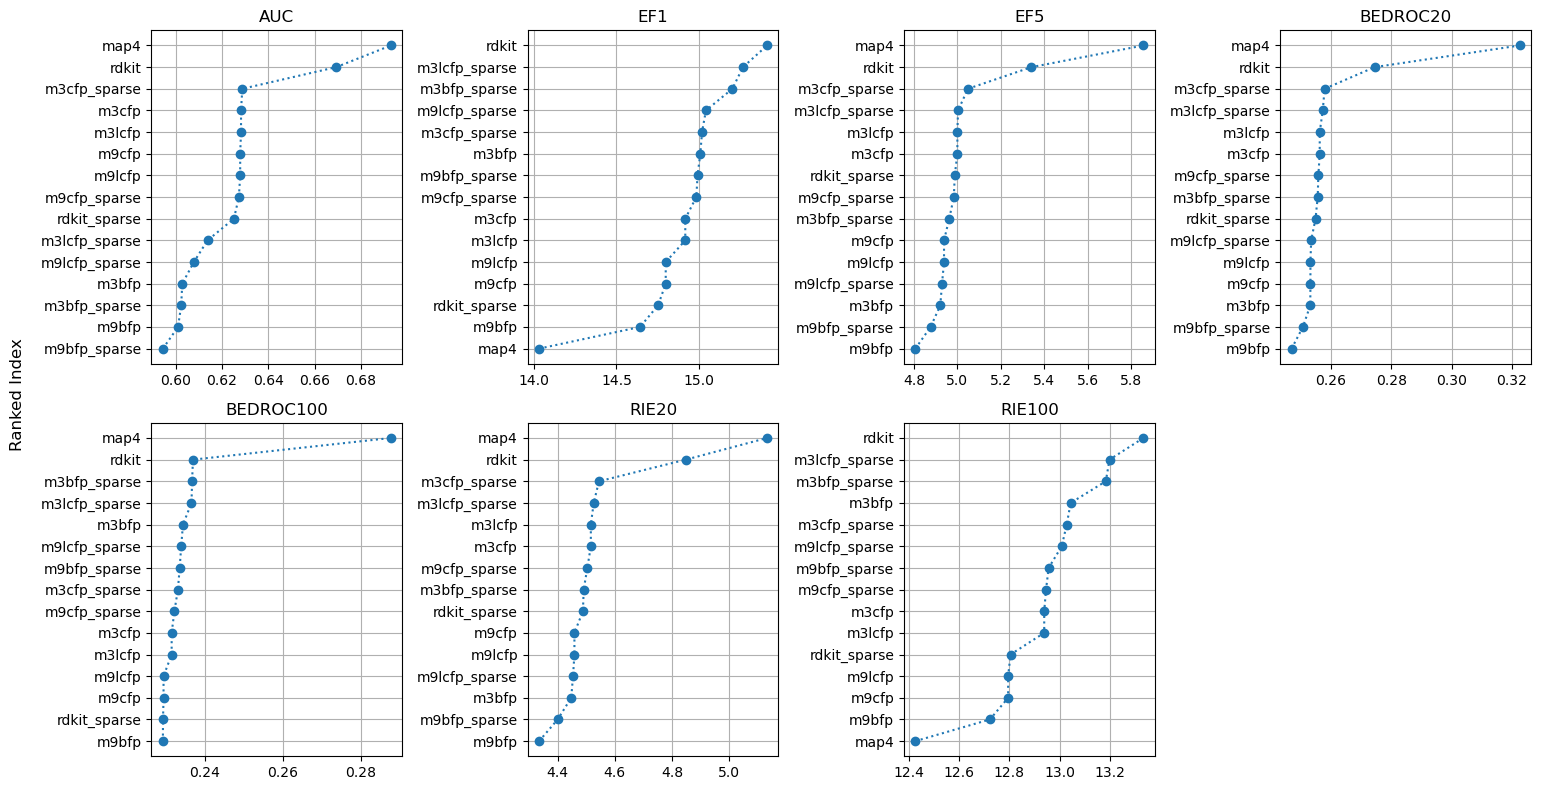

In [ ]:
# restrict to selected cases once
subset = metrics_combined_mean.loc[select_cases]

# how many metrics and grid shape
n_metrics = subset.shape[1]
n_cols = 4
n_rows = math.ceil(n_metrics / n_cols)

# no sharey, since each plot has its own ordering
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(4 * n_cols, 4 * n_rows))

axes_flat = axes.flatten()

for i, metric in enumerate(subset.columns):
    ax = axes_flat[i]
    # compute per‐metric ordering
    order = np.argsort(subset[metric].values)
    x = subset[metric].values[order]
    y = subset.index.values[order]

    ax.plot(x, y, "o:")
    ax.set_title(metric)
    ax.grid(True)

# hide any empty subplots
for ax in axes_flat[n_metrics:]:
    ax.set_visible(False)

# shared label on the left
fig.text(0.04, 0.5, 'Ranked Index',
         va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=(0.05, 0, 1, 1))
plt.savefig("ranking_metrics_comparison_global_mean.png", dpi=300)
plt.show()

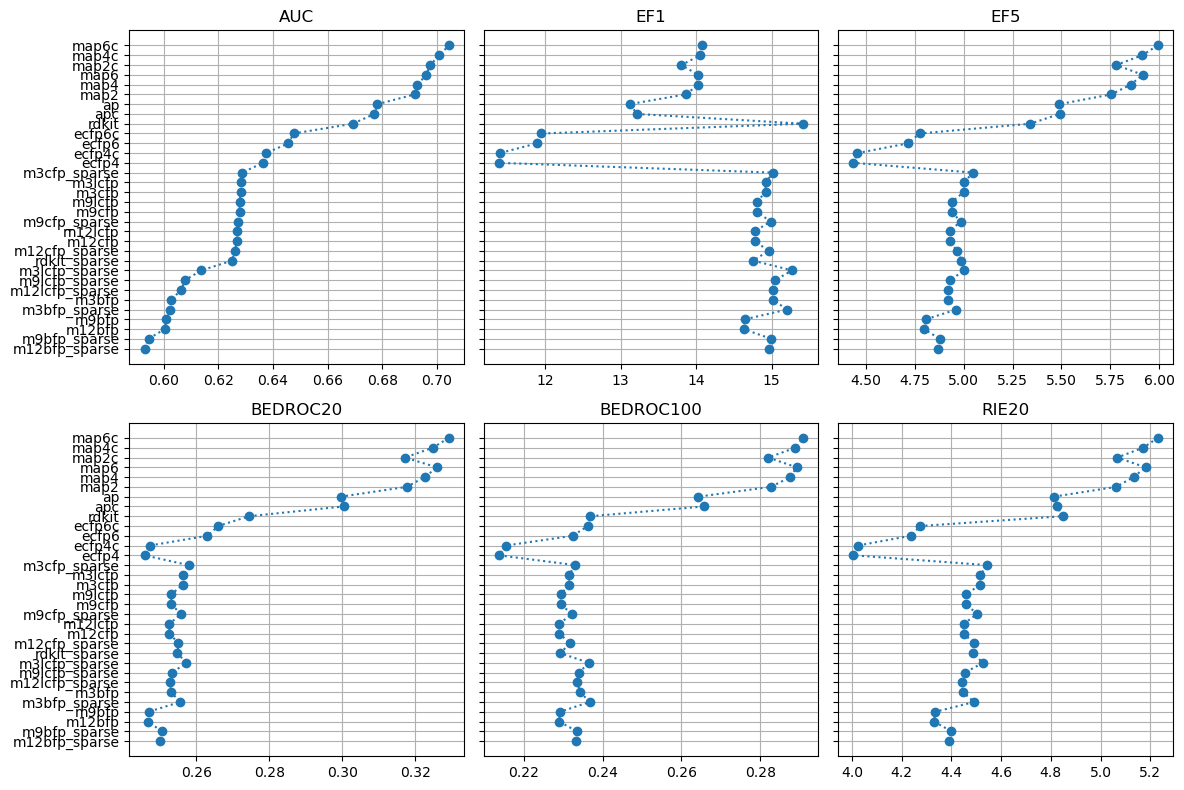

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

order = np.argsort(auc_ranked).values

# List of datasets and their corresponding axes
datasets = [
    auc_ranked, ef1_ranked, ef5_ranked, 
    bedroc20_ranked, bedroc100_ranked, rie20_ranked
]
labels = [
    "AUC", "EF1", "EF5", 
    "BEDROC20", "BEDROC100", "RIE20"
]

# Plot each dataset in its corresponding subplot
for ax, data, label in zip(axes.flat, datasets, labels):
    ax.plot(data.iloc[order].values, data.iloc[order].index, "o:")#, label=data.columns)
    ax.grid()
    ax.set_title(label)
    
# Shared y-axis label
#fig.text(0.04, 0.5, 'Ranked Index', va='center', rotation='vertical', fontsize=12)

#plt.legend()
plt.tight_layout()
plt.savefig("ranking_metrics_comparison_global_mean.png", dpi=300)
plt.show()

In [58]:
def calculate_ranked_list(metric_df):
    ranked = metric_df.rank(axis=1, ascending=False)
    return ranked.mean(axis=0)

# Calculate the fingerprint ranking for each metric
auc_ranked = calculate_ranked_list(auc)
ef1_ranked = calculate_ranked_list(ef1)
ef5_ranked = calculate_ranked_list(ef5)
bedroc20_ranked = calculate_ranked_list(bedroc20)
bedroc100_ranked = calculate_ranked_list(bedroc100)
rie20_ranked = calculate_ranked_list(rie20)
rie100_ranked = calculate_ranked_list(rie100)

# Combine all metrics into one dataframe
metrics_combined = pd.concat([auc_ranked, ef1_ranked, ef5_ranked, bedroc20_ranked, bedroc100_ranked, rie20_ranked, rie100_ranked], axis=1)
metrics_combined.columns = ['AUC', 'EF1', 'EF5', 'BEDROC20', 'BEDROC100', 'RIE20', 'RIE100']

In [59]:
metrics_combined

,AUC,EF1,EF5,BEDROC20,BEDROC100,RIE20,RIE100
map2c,9.430168,10.687151,10.128492,10.273743,10.927374,10.268156,10.960894
map2,10.078212,10.365922,10.765363,10.569832,10.955307,10.513966,10.938547
map4c,9.011173,9.756983,9.480447,9.636872,9.754190,9.631285,9.726257
map4,9.888268,10.058659,10.039106,10.150838,10.044693,10.139665,10.061453
map6c,8.407821,9.743017,9.340782,9.201117,9.620112,9.201117,9.586592
map6,9.256983,10.044693,9.790503,9.882682,9.905028,9.871508,9.837989
ecfp4c,15.215084,13.921788,14.639665,14.751397,14.175978,14.745810,14.220670
ecfp4,15.315642,14.036313,14.773743,14.801676,14.282123,14.796089,14.354749
ecfp6c,14.768156,14.229050,14.625698,14.695531,14.108939,14.678771,14.175978
ecfp6,15.231844,14.290503,14.715084,14.762570,14.226257,14.745810,14.332402


In [61]:
def calculate_combined_means_by_datset(metric_df):
    df = pd.DataFrame({
        "chembl": metric_df.iloc[:80, :].mean(axis=0),
        "dud": metric_df.iloc[80:101, :].mean(axis=0),
        "muv": metric_df.iloc[101:, :].mean(axis=0)
    })
    #ranked = metric_df.rank(axis=1, ascending=False)
    return df

# Calculate the fingerprint ranking for each metric
auc_ranked = calculate_combined_means_by_datset(auc)
ef1_ranked = calculate_combined_means_by_datset(ef1)
ef5_ranked = calculate_combined_means_by_datset(ef5)
bedroc20_ranked = calculate_combined_means_by_datset(bedroc20)
bedroc100_ranked = calculate_combined_means_by_datset(bedroc100)
rie20_ranked = calculate_combined_means_by_datset(rie20)
rie100_ranked = calculate_combined_means_by_datset(rie100)

# Combine all metrics into one dataframe
#metrics_combined_mean = pd.concat([auc_ranked, ef1_ranked, ef5_ranked, bedroc20_ranked, bedroc100_ranked, rie20_ranked, rie100_ranked], axis=1)
#metrics_combined_mean.columns = ['AUC', 'EF1', 'EF5', 'BEDROC20', 'BEDROC100', 'RIE20', 'RIE100']

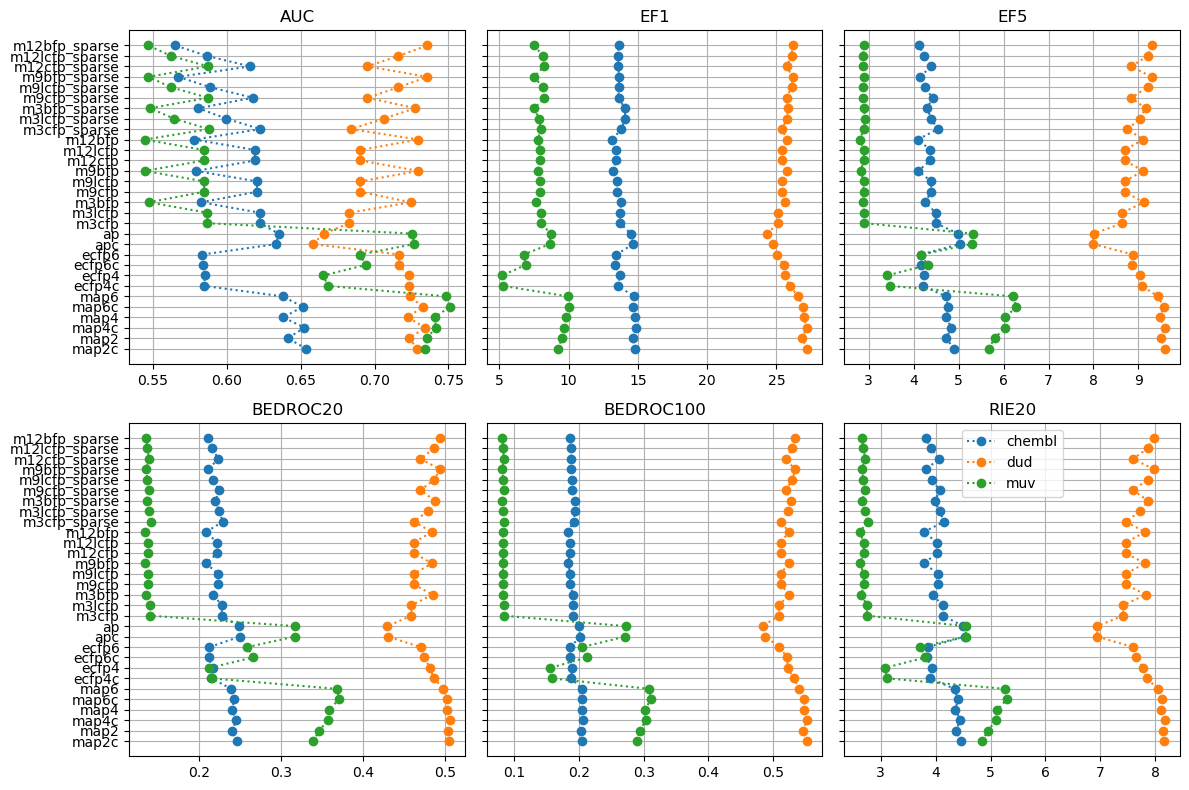

In [62]:
import matplotlib.pyplot as plt

# Assuming the data is already prepared
# auc_ranked, ef1_ranked, ef5_ranked, bedroc20_ranked, bedroc100_ranked, rie20_ranked, rie100_ranked

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

# List of datasets and their corresponding axes
datasets = [
    auc_ranked, ef1_ranked, ef5_ranked, 
    bedroc20_ranked, bedroc100_ranked, rie20_ranked
]
labels = [
    "AUC", "EF1", "EF5", 
    "BEDROC20", "BEDROC100", "RIE20"
]

# Plot each dataset in its corresponding subplot
for ax, data, label in zip(axes.flat, datasets, labels):
    ax.plot(data.values, data.index, "o:", label=data.columns)
    ax.grid()
    ax.set_title(label)
    
# Shared y-axis label
#fig.text(0.04, 0.5, 'Ranked Index', va='center', rotation='vertical', fontsize=12)

plt.legend()
plt.tight_layout()
plt.savefig("ranking_metrics_comparison_benchmarking_2025_06_03.png", dpi=300)
plt.show()

In [64]:
def calculate_ranked_list(metric_df):
    #ranked = metric_df.rank(axis=1, ascending=False)
    return metric_df.mean(axis=0)

# Calculate the fingerprint ranking for each metric
auc_ranked = calculate_ranked_list(auc)
ef1_ranked = calculate_ranked_list(ef1)
ef5_ranked = calculate_ranked_list(ef5)
bedroc20_ranked = calculate_ranked_list(bedroc20)
bedroc100_ranked = calculate_ranked_list(bedroc100)
rie20_ranked = calculate_ranked_list(rie20)
rie100_ranked = calculate_ranked_list(rie100)


In [65]:
order = np.argsort(auc_ranked).values
order

array([29, 26, 20, 17, 23, 14, 28, 25, 22, 27, 18, 19, 24, 15, 16, 13, 12,
       21,  7,  6,  9,  8, 10, 11,  1,  3,  5,  0,  2,  4])

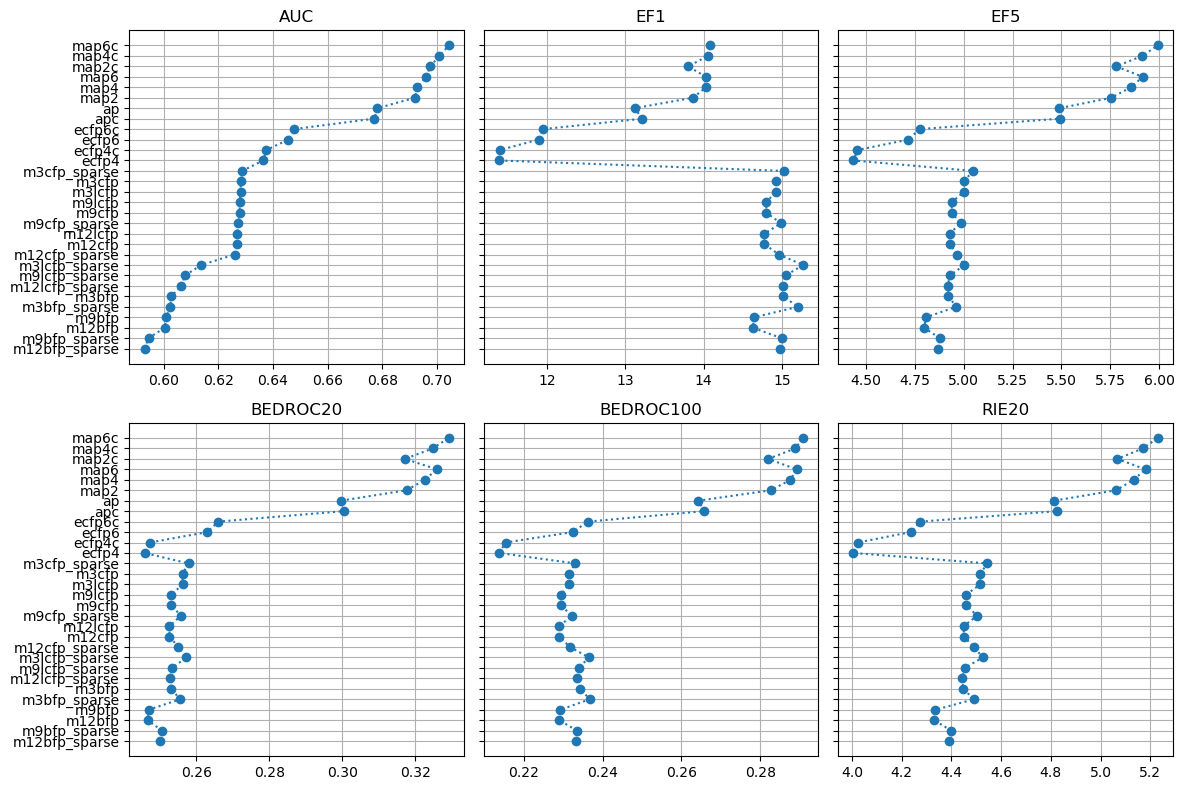

In [66]:
import matplotlib.pyplot as plt

# Assuming the data is already prepared
# auc_ranked, ef1_ranked, ef5_ranked, bedroc20_ranked, bedroc100_ranked, rie20_ranked, rie100_ranked

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

order = np.argsort(auc_ranked).values

# List of datasets and their corresponding axes
datasets = [
    auc_ranked, ef1_ranked, ef5_ranked, 
    bedroc20_ranked, bedroc100_ranked, rie20_ranked
]
labels = [
    "AUC", "EF1", "EF5", 
    "BEDROC20", "BEDROC100", "RIE20"
]

# Plot each dataset in its corresponding subplot
for ax, data, label in zip(axes.flat, datasets, labels):
    ax.plot(data.iloc[order].values, data.iloc[order].index, "o:")#, label=data.columns)
    ax.grid()
    ax.set_title(label)
    
# Shared y-axis label
#fig.text(0.04, 0.5, 'Ranked Index', va='center', rotation='vertical', fontsize=12)

#plt.legend()
plt.tight_layout()
plt.savefig("ranking_metrics_comparison_global_mean.png", dpi=300)
plt.show()

In [76]:
auc.columns

Index(['map2c', 'map2', 'map4c', 'map4', 'map6c', 'map6', 'ecfp4c', 'ecfp4',
       'ecfp6c', 'ecfp6', 'apc', 'ap', 'm3cfp', 'm3lcfp', 'm3bfp', 'm9cfp',
       'm9lcfp', 'm9bfp', 'm12cfp', 'm12lcfp', 'm12bfp', 'm3cfp_sparse',
       'm3lcfp_sparse', 'm3bfp_sparse', 'm9cfp_sparse', 'm9lcfp_sparse',
       'm9bfp_sparse', 'm12cfp_sparse', 'm12lcfp_sparse', 'm12bfp_sparse'],
      dtype='object')

In [87]:
to_drop = ["map2c", "map4c", "map6c", 'ecfp4c', 'ecfp4',
       'ecfp6c', 'ecfp6', 'apc', 'ap']

cols_select = [x for x in auc.columns if x not in to_drop]

In [61]:
cols_select = [
    'map2', 'map4', 'map6',
    #"map2c", "map4c", "map6c",
    "rdkit", #"rdkit_sparse",
    #'m3cfp_sparse',
    'm3lcfp_sparse',
    #'m9cfp_sparse', 
    #'m9lcfp_sparse', 
    #'m9bfp_sparse', 
    #'m12cfp_sparse', 
    'm12lcfp_sparse',
    #'m12bfp_sparse'
]

In [62]:
def calculate_ranked_list(metric_df):
    ranked = metric_df.rank(axis=1, ascending=False)
    return ranked.mean(axis=0)

# Calculate the fingerprint ranking for each metric
auc_ranked = calculate_ranked_list(auc[cols_select])
ef1_ranked = calculate_ranked_list(ef1[cols_select])
ef5_ranked = calculate_ranked_list(ef5[cols_select])
bedroc20_ranked = calculate_ranked_list(bedroc20[cols_select])
bedroc100_ranked = calculate_ranked_list(bedroc100[cols_select])
rie20_ranked = calculate_ranked_list(rie20[cols_select])
rie100_ranked = calculate_ranked_list(rie100[cols_select])

# Combine all metrics into one dataframe
metrics_combined = pd.concat([auc_ranked, ef1_ranked, ef5_ranked, bedroc20_ranked, bedroc100_ranked, rie20_ranked, rie100_ranked], axis=1)
metrics_combined.columns = ['AUC', 'EF1', 'EF5', 'BEDROC20', 'BEDROC100', 'RIE20', 'RIE100']

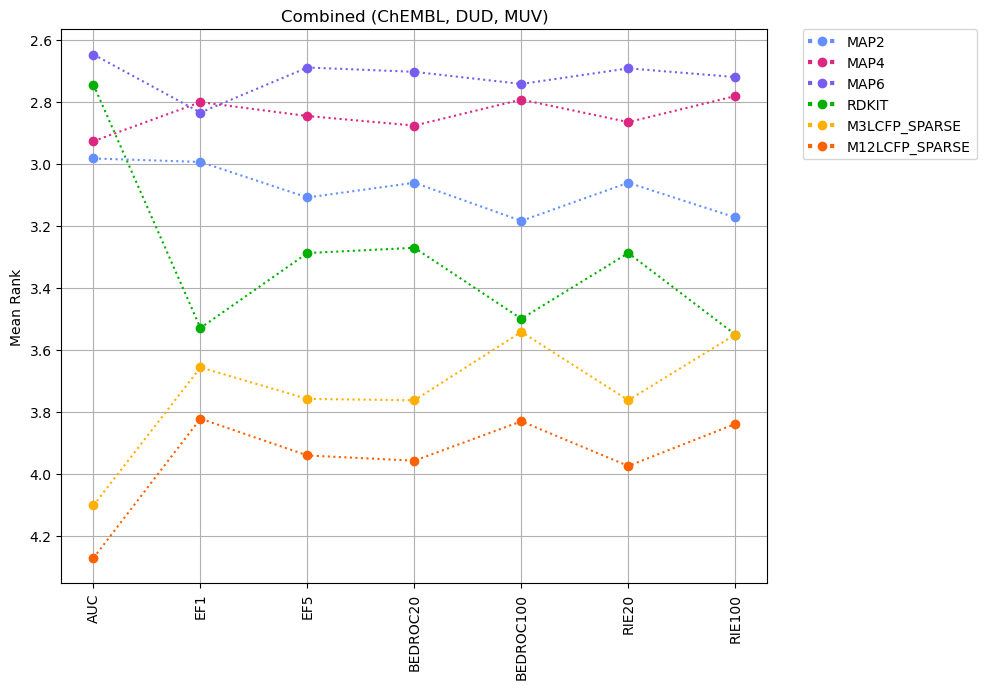

In [77]:
# Plot the fingerprint ranking for each metric in a line plot 
fig, ax = plt.subplots(figsize=(10, 7))

custom_labels = [s.upper() for s in cols_select]
custom_colors = ['#648FFF', '#DC267F', '#785EF0', '#00B000', '#FFB000', '#FE6100', 
                 '#00B000', '#22C7C6', '#44B033', '#66C7FF']

# Plot each row as a line
for i, (index, row) in enumerate(metrics_combined.iterrows()):
    ax.plot(
        metrics_combined.columns,
        row,
        "o:",
        label=custom_labels[i],
        
        color=custom_colors[i],
    )

# Set title and axis labels
plt.title("Combined (ChEMBL, DUD, MUV)")
ax.set_ylabel('Mean Rank')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Invert y-axis
plt.gca().invert_yaxis()

# Add legend in the middle 
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Change the line width for the legend
for line in lgd.get_lines():
    line.set_linewidth(3.0)

plt.grid(True)
# Show the plot
plt.tight_layout()
plt.savefig('ranking_metrics_comparison_selected.png', dpi=600, bbox_inches='tight')

# Peptides

In [88]:
datasets = [
    #'ChEMBL',
    #'DUD',
    #'MUV',
    'PeptidesM',
    'Peptides',
]

In [89]:
# Define the number of queries and the names of the used fingerprints
num_queries = 5

# Generate the column names from the fingerprint names and the number of queries
distance_columns = []
for fingerprint in fingerprint_names:
    for query_num in range(num_queries):
        distance_columns.append(f"{fingerprint}_{query_num}")


datasets = ['PeptidesM', 'Peptides']
for dataset in datasets:
    print(dataset)
    dataset_path = f'../benchmarking/{dataset}'
    output_dir = f'{dataset}'
    
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Iterate over all files in the dataset directory
    for file in tqdm(os.listdir(dataset_path)):
        if file.endswith('scored_2025_03.csv'):
    
            # Load the data
            data = pd.read_csv(os.path.join(dataset_path, file))
    
            # Calculate the AUC, EF1, EF5, BEDROC20, BEDROC100, RIE20, and RIE100 for each column. Reshape the results to a 2D array with the shape (len(fingerprint_names), num_queries)
            aucs = np.array([calc_auc(data, column_name) for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            ef1s = np.array([calc_ef1(data, column_name)[0] for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            ef5s = np.array([calc_ef5(data, column_name)[0]for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            bedroc20s = np.array([calc_bedroc20(data, column_name) for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            bedroc100s = np.array([calc_bedroc100(data, column_name) for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            rie20s = np.array([calc_rie20(data, column_name) for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
            rie100s = np.array([calc_rie100(data, column_name) for column_name in distance_columns]).reshape(len(fingerprint_names), num_queries)
    
            # For each fingerprint, determine the mean and std. dev of the 5 queries 
            aucs_mean = np.mean(aucs, axis=1)
            aucs_std = np.std(aucs, axis=1)
            ef1s_mean = np.mean(ef1s, axis=1)
            ef1s_std = np.std(ef1s, axis=1)
            ef5s_mean = np.mean(ef5s, axis=1)
            ef5s_std = np.std(ef5s, axis=1)
            bedroc20s_mean = np.mean(bedroc20s, axis=1)
            bedroc20s_std = np.std(bedroc20s, axis=1)
            bedroc100s_mean = np.mean(bedroc100s, axis=1)
            bedroc100s_std = np.std(bedroc100s, axis=1)
            rie20s_mean = np.mean(rie20s, axis=1)
            rie20s_std = np.std(rie20s, axis=1)
            rie100s_mean = np.mean(rie100s, axis=1)
            rie100s_std = np.std(rie100s, axis=1)
    
            # Generate a dataframe with the results
            output_df = pd.DataFrame({'fingerprint': fingerprint_names, 'auc_mean': aucs_mean, 'auc_std': aucs_std, 'ef1_mean': ef1s_mean, 'ef1_std': ef1s_std, 'ef5_mean': ef5s_mean, 'ef5_std': ef5s_std, 'bedroc20_mean': bedroc20s_mean, 'bedroc20_std': bedroc20s_std, 'bedroc100_mean': bedroc100s_mean, 'bedroc100_std': bedroc100s_std, 'rie20_mean': rie20s_mean, 'rie20_std': rie20s_std, 'rie100_mean': rie100s_mean, 'rie100_std': rie100s_std})
            
            # Save the results to a csv file
            filename = file.split('_')[0] + '_' + file.split('_')[1]
            output_df.to_csv(f'{dataset}/{filename}_peptides_validated_2025_03.csv', index=False)


PeptidesM


  0%|          | 0/92 [00:00<?, ?it/s]

Peptides


  0%|          | 0/93 [00:00<?, ?it/s]

In [90]:
metrics = ['auc_mean', 'ef1_mean', 'ef5_mean', 'bedroc20_mean', 'bedroc100_mean', 'rie20_mean', 'rie100_mean']

datasets = ['PeptidesM', 'Peptides']

fingerprint_names = [
    'map2c', 'map2',
    'map4c', 'map4',
    'map6c', 'map6',
    'ecfp4c', 'ecfp4', 'ecfp6c', 'ecfp6', 'apc', 'ap',
    'rdkit',
    'rdkit_sparse',
    'm3cfp',
    'm3lcfp',
    'm3bfp',
    'm9cfp',
    'm9lcfp',
    'm9bfp',
    'm12cfp',
    'm12lcfp',
    'm12bfp',
    'm3cfp_sparse',
    'm3lcfp_sparse',
    'm3bfp_sparse',
    'm9cfp_sparse',
    'm9lcfp_sparse',
    'm9bfp_sparse',
    'm12cfp_sparse',
    'm12lcfp_sparse',
    'm12bfp_sparse'
]


#for dataset in datasets:
# Iterate over metrics
for metric in metrics:

    # Initialize output dataframe
    output_df = pd.DataFrame(columns=fingerprint_names)

    # Iterate over datasets
    for dataset in datasets:
        dataset_path = f'../../map4chiral/benchmark/validation/{dataset}'

        # Iterate over files
        for file in os.listdir(dataset_path):
            data = pd.read_csv(os.path.join(dataset_path, file))[metric].values
            output_df.loc[len(output_df), fingerprint_names[:12]] = data

    # Iterate over datasets
    count = 0
    for dataset in datasets:
        dataset_path = f'{dataset}'

        # Iterate over files
        for i, file in enumerate(os.listdir(dataset_path)):
            if file.endswith('2025_03.csv'):
                data = pd.read_csv(os.path.join(dataset_path, file))[metric].values
                output_df.loc[count, fingerprint_names[12:]] = data
                count += 1
    
    # Create output directory
    if not os.path.exists('combined_sets'):
        os.makedirs('combined_sets')
    
    # Save output dataframe
    output_df.to_csv(f'combined_sets/{metric}_peptides_benchmarking_2025_06_03.csv', index=False)

In [95]:
auc = pd.read_csv('combined_sets/auc_mean_peptides_benchmarking_2025_06_03.csv')
ef1 = pd.read_csv('combined_sets/ef1_mean_peptides_benchmarking_2025_06_03.csv')
ef5 = pd.read_csv('combined_sets/ef5_mean_peptides_benchmarking_2025_06_03.csv')
bedroc20 = pd.read_csv('combined_sets/bedroc20_mean_peptides_benchmarking_2025_06_03.csv')
bedroc100 = pd.read_csv('combined_sets/bedroc100_mean_peptides_benchmarking_2025_06_03.csv')
rie20 = pd.read_csv('combined_sets/rie20_mean_peptides_benchmarking_2025_06_03.csv')
rie100 = pd.read_csv('combined_sets/rie100_mean_peptides_benchmarking_2025_06_03.csv')

In [96]:
def calculate_combined_mean(metric_df):
    #ranked = metric_df.rank(axis=1, ascending=False)
    return metric_df.mean(axis=0)

# Calculate the fingerprint ranking for each metric
auc_ranked = calculate_combined_mean(auc)
ef1_ranked = calculate_combined_mean(ef1)
ef5_ranked = calculate_combined_mean(ef5)
bedroc20_ranked = calculate_combined_mean(bedroc20)
bedroc100_ranked = calculate_combined_mean(bedroc100)
rie20_ranked = calculate_combined_mean(rie20)
rie100_ranked = calculate_combined_mean(rie100)

# Combine all metrics into one dataframe
metrics_combined_mean = pd.concat([auc_ranked, ef1_ranked, ef5_ranked, bedroc20_ranked, bedroc100_ranked, rie20_ranked, rie100_ranked], axis=1)
metrics_combined_mean.columns = ['AUC', 'EF1', 'EF5', 'BEDROC20', 'BEDROC100', 'RIE20', 'RIE100']

In [97]:
metrics_combined_mean

,AUC,EF1,EF5,BEDROC20,BEDROC100,RIE20,RIE100
map2c,0.782335,9.525271,6.454597,0.395601,0.346574,5.448444,9.097001
map2,0.783088,9.838283,6.606301,0.404141,0.352140,5.565286,9.224028
map4c,0.792001,9.981772,6.891772,0.417954,0.363418,5.755362,9.512631
map4,0.790824,10.080319,6.884360,0.418540,0.361896,5.766560,9.530607
map6c,0.803352,10.447874,7.220155,0.435258,0.373454,6.005820,9.876472
map6,0.800800,10.390304,7.098381,0.430909,0.370404,5.952121,9.848257
ecfp4c,0.701719,4.488765,3.637409,0.238109,0.179535,3.243152,4.433038
ecfp4,0.697755,4.405231,3.564012,0.233535,0.175676,3.180825,4.331155
ecfp6c,0.736024,6.616321,4.737433,0.302460,0.248081,4.143669,6.456434
ecfp6,0.731187,6.458054,4.556376,0.293947,0.239194,4.028521,6.258636


In [98]:
metrics_combined_mean.to_csv("ranking_task_peptides_benchmarking_results.csv", index=False)

In [103]:
select_cases = [
    #'map4c',
    'map4',
    'rdkit',
    'rdkit_sparse',
    'm3cfp',
    'm3lcfp',
    'm3bfp',
    'm9cfp',
    'm9lcfp',
    'm9bfp',
    #'m12cfp',
    #'m12lcfp',
    #'m12bfp',
    'm3cfp_sparse',
    'm3lcfp_sparse',
    'm3bfp_sparse',
    'm9cfp_sparse',
    'm9lcfp_sparse',
    'm9bfp_sparse',
    #'m12cfp_sparse',
    #'m12lcfp_sparse',
    #'m12bfp_sparse'    
]

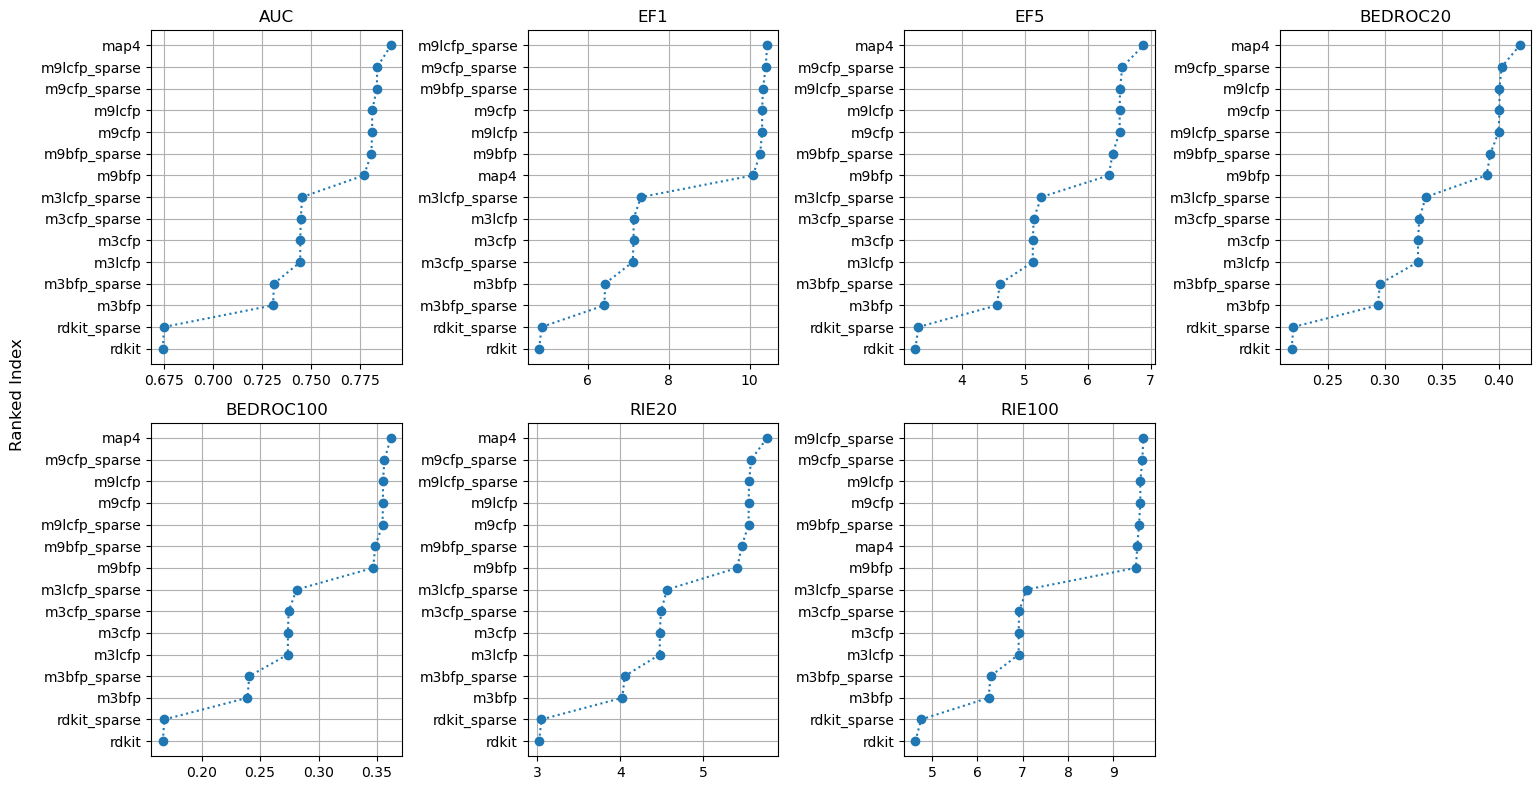

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import math

# restrict to your selected cases once
subset = metrics_combined_mean.loc[select_cases]

# how many metrics and grid shape
n_metrics = subset.shape[1]
n_cols = 4
n_rows = math.ceil(n_metrics / n_cols)

# no sharey, since each plot has its own ordering
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(4 * n_cols, 4 * n_rows))

axes_flat = axes.flatten()

for i, metric in enumerate(subset.columns):
    ax = axes_flat[i]
    # compute per‐metric ordering
    order = np.argsort(subset[metric].values)
    x = subset[metric].values[order]
    y = subset.index.values[order]

    ax.plot(x, y, "o:")
    ax.set_title(metric)
    ax.grid(True)

# hide any empty subplots
for ax in axes_flat[n_metrics:]:
    ax.set_visible(False)

# shared label on the left
fig.text(0.04, 0.5, 'Ranked Index',
         va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=(0.05, 0, 1, 1))
plt.savefig("ranking_metrics_comparison_peptides_mean.png", dpi=300)
plt.show()

In [105]:
def calculate_ranked_list(metric_df):
    ranked = metric_df.rank(axis=1, ascending=False)
    return ranked.mean(axis=0)

# Calculate the fingerprint ranking for each metric
auc_ranked = calculate_ranked_list(auc[cols_select])
ef1_ranked = calculate_ranked_list(ef1[cols_select])
ef5_ranked = calculate_ranked_list(ef5[cols_select])
bedroc20_ranked = calculate_ranked_list(bedroc20[cols_select])
bedroc100_ranked = calculate_ranked_list(bedroc100[cols_select])
rie20_ranked = calculate_ranked_list(rie20[cols_select])
rie100_ranked = calculate_ranked_list(rie100[cols_select])

# Combine all metrics into one dataframe
metrics_combined = pd.concat([auc_ranked, ef1_ranked, ef5_ranked, bedroc20_ranked, bedroc100_ranked, rie20_ranked, rie100_ranked], axis=1)
metrics_combined.columns = ['AUC', 'EF1', 'EF5', 'BEDROC20', 'BEDROC100', 'RIE20', 'RIE100']

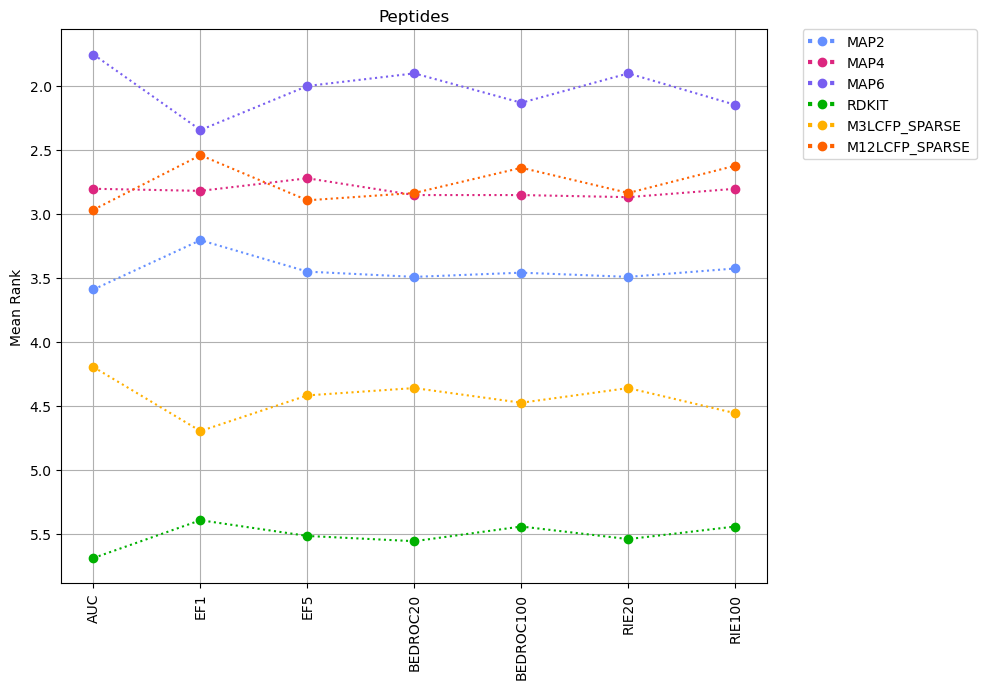

In [106]:
# Plot the fingerprint ranking for each metric in a line plot 
fig, ax = plt.subplots(figsize=(10, 7))

custom_labels = [s.upper() for s in cols_select]
custom_colors = ['#648FFF', '#DC267F', '#785EF0', '#00B000', '#FFB000', '#FE6100', 
                 '#00B000', '#22C7C6', '#44B033', '#66C7FF']

# Plot each row as a line
for i, (index, row) in enumerate(metrics_combined.iterrows()):
    ax.plot(
        metrics_combined.columns,
        row,
        "o:",
        label=custom_labels[i],
        
        color=custom_colors[i],
    )

# Set title and axis labels
plt.title("Peptides")
ax.set_ylabel('Mean Rank')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Invert y-axis
plt.gca().invert_yaxis()

# Add legend in the middle 
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Change the line width for the legend
for line in lgd.get_lines():
    line.set_linewidth(3.0)

plt.grid(True)
# Show the plot
plt.tight_layout()
plt.savefig('ranking_metrics_comparison_peptides_selected.png', dpi=600, bbox_inches='tight')